# Bonus1: Parallel Algorithms

### Name: [Chenxu Wang]


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Parallel/Parallel.pdf)

2. Implement federated averaging or decentralized optimization.

3. Plot the convergence curve. (The x-axis can be ```number of epochs``` or ```number of communication```. You must make sure the label is correct.)

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo. (If it is submitted to Google Drive or Dropbox, you must make the file open-access.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus1/Bonus1.html



# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [1]:
import numpy as np

In [2]:
from sklearn import datasets
import numpy


x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [3]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [4]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[-0.17956863 -0.02353761 -0.10179319 -0.06414391 -0.06712633 -0.07623858
  -0.09847241 -0.07449868]]
test std = 
[[0.92237931 0.97876213 1.22879716 0.96536265 0.98563543 1.00910107
  0.77305595 0.96906312]]


## 1.4. Add a dimension of all ones

In [5]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


# Federated Averaging

In [6]:
class FedAvgWorker:
    def __init__(self, x, y):
        self.x = x # sxd local feature matrix
        self.y = y # sx1 local label matrix
        self.s = x.shape[0] # number of local samples
        self.d = x.shape[1] # number of features
        self.w = numpy.zeros((d,1)) # dx1 model paraemeter vector
        self.momentum = 0 # scalar
    
    # Set the model parameters to the dataset
    def set_param(self, w):
        self.w = w
    
    # Computer the local loss
    def loss(self):
        yx = numpy.multiply(self.y, self.x) # sxd
        yxw = numpy.dot(yx, self.w) # sx1
        vec1 = numpy.exp(-yxw) # sx1
        vec2 = numpy.log(1 + vec1) # sx1
        return numpy.sum(vec2) # loss function
    
    # Compute the local gradient
    def gradient(self, lam):
        yx = numpy.multiply(self.y, self.x) # sxd
        yxw = numpy.dot(yx, self.w) # sx1
        vec1 = numpy.exp(yxw) # sx1
        vec2 = numpy.divide(yx, 1 + vec1) # sxd
        vec3 = -numpy.sum(vec2, axis = 0).reshape(self.d, 1) # dx1
        g = vec3 + lam * self.w
        return g
    
    # Run gradient descent
    def GD(self, q, lr, beta, lam):
        w0 = self.w
        
        for i in range(q):
            gradient = self.gradient(lam)
            self.momentum *= beta
            self.momentum += gradient
            self.w -= lr * self.momentum
        return w0 - self.w
                
        
    
    # Compute the stochastic gradient
    def stochastic_gradient(self, xi, yi, lam):
        yx =numpy.multiply(yi, xi)
        yxw = float(np.dot(yx, w))
        
        g_loss = -yx.T / (1 + numpy.exp(yxw)) # yx1
        g = g_loss + lam * self.w # dx1
        return g
    # Run stochastic gradient descent
    def SGD(self, q, lr, beta, lam):
        w0 = self.w
        
        for t in range(q):
            rand = np.random.permutation(self.s)
            x_rand = self.x[rand, :]
            y_rand = self.y[rand]
            
            for i in range(self.s):
                xi = x_rand[i, :]
                yi = float(y_rand[i])
                g = self.stochastic_gradient(xi, yi, lam)
                self.w -= lr * g
        
        return w0 - self.w
        

In [7]:
class FedAvgServer:
    def __init__(self, m, n, d):
        self.m = m # number of worker nodes
        self.n = n # number of training samples
        self.d = d # number of features
        
        self.w = numpy.zeros((d,1)) # dx1 model parameter vector
        self.g = numpy.zeros((d,1)) # dx1 gradient
        self.v = numpy.zeros((d,1)) # dx1 momentum
        self.loss = 0 # loss function value
        self.obj = 0 # objective function value
        
    def broadcast(self):
        return self.w


    def aggregate(self, ps, losses):
        self.p = numpy.mean(ps, axis = 0).reshape(self.d, 1)
        self.loss = numpy.sum(losses)
        
    
    # Computer the objective function (sum of loss and regularization)
    def objective(self, lam):
        reg = lam / 2 * numpy.sum(self.w * self.w)
        self.obj = self.loss / self.n + reg
        return self.obj
    
    def agd(self, lr):
        self.w -= lr * self.p

In [8]:
import math

# Create a server and m worker nodes
def create_server_workers(m, x, y):
    n, d = x.shape
    s = math.floor(n / m)
    server = FedAvgServer(m, n, d)
    workers = []
    
    for i in range(m):
        indices = list(range(i*s, (i+1)*s))
        worker = FedAvgWorker(x[indices, :], y[indices, :])
        workers.append(worker)
        
    return server, workers

# GD q = 8

In [9]:
m = 4
lam = 1E-6 # regularization parameter
learning_rate = 1E-4
beta = 0.9
max_epoch = 50
q = 8

gd_q8_server, gd_q8_workers = create_server_workers(m, x_train, y_train)

In [10]:

objvals_gd_q8 = []
for t in range(max_epoch):
    # step 1: broadcast
    w = gd_q8_server.broadcast()
    for i in range(m):
        gd_q8_workers[i].set_param(w)
    
    # step 2: workers' local computations
    ps = []
    losses = []
    for i in range(m):
        p = gd_q8_workers[i].GD(q, learning_rate, beta, lam)
        ps.append(p.squeeze())
        l = gd_q8_workers[i].loss()
        losses.append(l)
    
    # step 3: aggregate the workers' outputs
    gd_q8_server.aggregate(ps, losses)
    
    # step 4: server update the model parameters
    obj = gd_q8_server.objective(lam) # compute objective function
    print('Objective function value = ' + str(obj))
    gd_q8_server.agd(learning_rate) # updates the model partameters

    objvals_gd_q8.append(obj)

Objective function value = 0.6025714123635149
Objective function value = 0.51693249455322
Objective function value = 0.49222330836293526
Objective function value = 0.4859078974170336
Objective function value = 0.4840830282025134
Objective function value = 0.4834348695874717
Objective function value = 0.4828735616136389
Objective function value = 0.48259398182827523
Objective function value = 0.4825221078035693
Objective function value = 0.4824910680157493
Objective function value = 0.4824732620510459
Objective function value = 0.482466373383299
Objective function value = 0.4824617909275841
Objective function value = 0.4824589559093751
Objective function value = 0.4824588168646976
Objective function value = 0.48245980083722745
Objective function value = 0.4824602987631244
Objective function value = 0.4824599387790637
Objective function value = 0.4824591322774705
Objective function value = 0.4824583890180608
Objective function value = 0.4824579389986211
Objective function value = 0.48245

# GD q = 1

In [11]:
m = 4
lam = 1E-6 # regularization parameter
learning_rate = 1E-4
beta = 0.9
max_epoch = 50
q = 1

gd_q1_server, gd_q1_workers = create_server_workers(m, x_train, y_train)

In [12]:

objvals_gd_q1 = []
for t in range(max_epoch):
    # step 1: broadcast
    w = gd_q1_server.broadcast()
    for i in range(m):
        gd_q1_workers[i].set_param(w)
    
    # step 2: workers' local computations
    ps = []
    losses = []
    for i in range(m):
        p = gd_q1_workers[i].GD(q, learning_rate, beta, lam)
        ps.append(p.squeeze())
        l = gd_q1_workers[i].loss()
        losses.append(l)
    
    # step 3: aggregate the workers' outputs
    gd_q1_server.aggregate(ps, losses)
    
    # step 4: server update the model parameters
    obj = gd_q1_server.objective(lam) # compute objective function
    print('Objective function value = ' + str(obj))
    gd_q1_server.agd(learning_rate) # updates the model partameters

    objvals_gd_q1.append(obj)

Objective function value = 0.6883711915002282
Objective function value = 0.6770143696815892
Objective function value = 0.6608296941932269
Objective function value = 0.6417154348031102
Objective function value = 0.6214556644063608
Objective function value = 0.6015258604811118
Objective function value = 0.5829884138951628
Objective function value = 0.5664810636197536
Objective function value = 0.5522758496313597
Objective function value = 0.5403732742532951
Objective function value = 0.5306000726672775
Objective function value = 0.522691503782779
Objective function value = 0.5163513125640646
Objective function value = 0.5112903308229783
Objective function value = 0.5072481124792202
Objective function value = 0.504002615926549
Objective function value = 0.5013722397728008
Objective function value = 0.49921342629148596
Objective function value = 0.4974160226764339
Objective function value = 0.4958977899391184
Objective function value = 0.4945988843583835
Objective function value = 0.493476

# SGD q =1

In [13]:
m = 4
lam = 1E-6 # regularization parameter
learning_rate = 1E-4
beta = 0.9
max_epoch = 50
q = 1

sgd_q1_server, sgd_q1_workers = create_server_workers(m, x_train, y_train)

In [14]:

objvals_sgd_q1 = []
for t in range(max_epoch):
    # step 1: broadcast
    w = sgd_q1_server.broadcast()
    for i in range(m):
        sgd_q1_workers[i].set_param(w)
    
    # step 2: workers' local computations
    ps = []
    losses = []
    for i in range(m):
        p = sgd_q1_workers[i].SGD(q, learning_rate, beta, lam)
        ps.append(p.squeeze())
        l = sgd_q1_workers[i].loss()
        losses.append(l)
    
    # step 3: aggregate the workers' outputs
    sgd_q1_server.aggregate(ps, losses)
    
    # step 4: server update the model parameters
    obj = sgd_q1_server.objective(lam) # compute objective function
    print('Objective function value = ' + str(obj))
    sgd_q1_server.agd(learning_rate) # updates the model partameters

    objvals_sgd_q1.append(obj)

Objective function value = 0.6883864229211212
Objective function value = 0.6811347505700738
Objective function value = 0.674248002218547
Objective function value = 0.6677014593657795
Objective function value = 0.6614779915192472
Objective function value = 0.6555598572813642
Objective function value = 0.6499284975328349
Objective function value = 0.6445672244472005
Objective function value = 0.6394587923364974
Objective function value = 0.6345907933195664
Objective function value = 0.6299465812463769
Objective function value = 0.6255135842146174
Objective function value = 0.6212808430889389
Objective function value = 0.6172365266513227
Objective function value = 0.613369991957356
Objective function value = 0.6096714755361294
Objective function value = 0.6061315665549557
Objective function value = 0.602740672744736
Objective function value = 0.5994907449260662
Objective function value = 0.596374156277199
Objective function value = 0.593383596222856
Objective function value = 0.5905122922

# SGD q =8

In [15]:
m = 4
lam = 1E-6 # regularization parameter
learning_rate = 1E-4
beta = 0.9
max_epoch = 50
q = 8

sgd_q8_server, sgd_q8_workers = create_server_workers(m, x_train, y_train)

In [16]:

objvals_sgd_q8 = []
for t in range(max_epoch):
    # step 1: broadcast
    w = sgd_q8_server.broadcast()
    for i in range(m):
        sgd_q8_workers[i].set_param(w)
    
    # step 2: workers' local computations
    ps = []
    losses = []
    for i in range(m):
        p = sgd_q8_workers[i].SGD(q, learning_rate, beta, lam)
        ps.append(p.squeeze())
        l = sgd_q8_workers[i].loss()
        losses.append(l)
    
    # step 3: aggregate the workers' outputs
    sgd_q8_server.aggregate(ps, losses)
    
    # step 4: server update the model parameters
    obj = sgd_q8_server.objective(lam) # compute objective function
    print('Objective function value = ' + str(obj))
    sgd_q8_server.agd(learning_rate) # updates the model partameters

    objvals_sgd_q8.append(obj)

Objective function value = 0.6596630638741423
Objective function value = 0.6199435199675158
Objective function value = 0.5923482138250817
Objective function value = 0.5724329203225925
Objective function value = 0.557558233370046
Objective function value = 0.5461193713531203
Objective function value = 0.5371079296835104
Objective function value = 0.5298664290560171
Objective function value = 0.5239513345748298
Objective function value = 0.5190531441687171
Objective function value = 0.5149504213874847
Objective function value = 0.5114804198402584
Objective function value = 0.5085213239317112
Objective function value = 0.5059797102123167
Objective function value = 0.5037836125084275
Objective function value = 0.5018759898232901
Objective function value = 0.5002111404166555
Objective function value = 0.49875158833437666
Objective function value = 0.49746740962405633
Objective function value = 0.49633378997366623
Objective function value = 0.49532972593812374
Objective function value = 0.49

/Users/wangchenxu/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  
/Users/wangchenxu/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  if __name__ == '__main__':
/Users/wangchenxu/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  # Remove the CWD from sys.path while we load stuff.
/Users/wangchenxu/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be remov

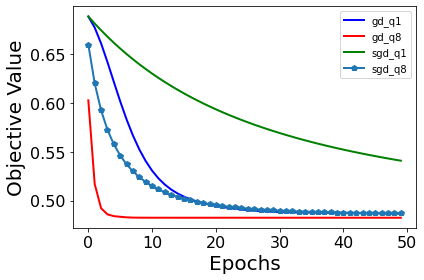

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_sgd_q8))

line0, = plt.plot(epochs_gd, objvals_gd_q1, '-b', LineWidth=2, )
line1, = plt.plot(epochs_gd, objvals_gd_q8, '-r', LineWidth=2)
line2, = plt.plot(epochs_gd, objvals_sgd_q1, '-g', LineWidth=2)
line3, = plt.plot(epochs_gd, objvals_sgd_q8, '-p', LineWidth=2)

plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1, line2, line3], ['gd_q1', 'gd_q8', 'sgd_q1', 'sgd_q8'])
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)